# Deep Learning with Pytorch Step-by-Step Practices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
np.random.seed(42)
torch.manual_seed(13)

## Regression

In [3]:
# Generate noisy data as fake training data

## Ground truth parameters
true_b = 1
true_w = 2
N = 100

## Data generation
x = np.random.rand(N, 1)
epsilon = 0.1 * np.random.randn(N, 1)
y = true_b + true_w * x + epsilon

In [4]:
# Train test split with numpy

## Shuffles the indices
idx = np.arange(N)
np.random.shuffle(idx)

train_idx = idx[:int(N * 0.8)]
val_idx = idx[int(N * 0.8):]

x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

(<Figure size 864x432 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f72138d6c70>,
       dtype=object))

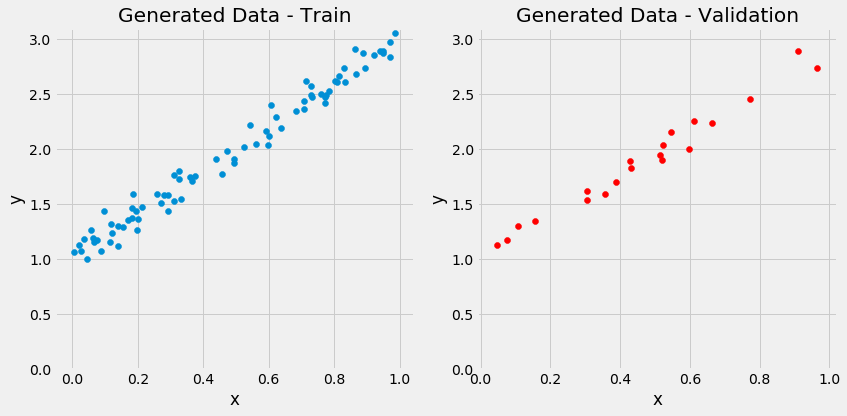

In [5]:
def figure1(x_train, y_train, x_val, y_val):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    ax[0].scatter(x_train, y_train)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_ylim([0, 3.1])
    ax[0].set_title('Generated Data - Train')

    ax[1].scatter(x_val, y_val, c='r')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    ax[1].set_ylim([0, 3.1])
    ax[1].set_title('Generated Data - Validation')
    fig.tight_layout()
    
    return fig, ax
figure1(x_train, y_train, x_val, y_val)

### Step 1. Data preparation

In [6]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [7]:
# Transform numpy training data into torch tensor
# Load the tensor into a data loader

x_tensor = torch.as_tensor(x).float()
y_tensor = torch.as_tensor(y).float()

dataset = TensorDataset(x_tensor, y_tensor)

## Train test split with torch
ratio = 0.8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

## Build a loader
train_loader=DataLoader(
    dataset=train_data,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_data, batch_size=16)

### Step 2. Model creation

In [8]:
import torch.optim as optim
import torch.nn as nn

In [9]:
# Create the neural network architecture and define training hyperparameters

lr = 0.1

model = nn.Sequential(nn.Linear(1, 1))
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=lr)

In [10]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[-0.0689]])), ('0.bias', tensor([0.2756]))])


### Step 3. Training process

In [11]:
import datetime

from torch.utils.tensorboard import SummaryWriter

In [12]:
class ModelTrainer(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        
        self.train_loader = None
        self.val_loader = None
        self.writer = None

        self.losses = []
        self.val_losses = []
        self.total_epochs = 0
        
        # Creates helper function for a training step
        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()
        
    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)  
            
    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader 
        # (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to create a SummaryWriter to 
        # interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter(f'{folder}/{name}_{suffix}')
        
    def _make_train_step(self):
        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "b" and "w" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the
            # learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step

    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, 
            # since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step
    
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step
        else:
            data_loader = self.train_loader
            step_fn = self.train_step

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)

        return loss
    
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
        
    def train(self, n_epochs, verbose=True, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)
    
        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)
                
            if verbose:
                print(f'[Epoch {epoch}]')
                print(f'training loss: {loss}, validation loss: {val_loss}')

        if self.writer:
            # Flushes the writer
            self.writer.flush()
            
    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training 
    
    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig
    
    def add_graph(self):
        if self.train_loader and self.writer:
            # Fetches a single mini-batch so we can use add_graph
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

In [13]:
model_trainer = ModelTrainer(model, loss_fn, optimizer)
model_trainer.set_loaders(train_loader, val_loader)
model_trainer.set_tensorboard('classy')

2023-01-11 23:44:26.767358: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [14]:
test_data = np.arange(0, 1.1, 0.1).reshape(-1, 1)
test_data

array([[0. ],
       [0.1],
       [0.2],
       [0.3],
       [0.4],
       [0.5],
       [0.6],
       [0.7],
       [0.8],
       [0.9],
       [1. ]])

In [15]:
predictions = model_trainer.predict(test_data)
predictions

array([[0.27555907],
       [0.2686718 ],
       [0.26178455],
       [0.2548973 ],
       [0.24801004],
       [0.24112278],
       [0.23423553],
       [0.22734827],
       [0.22046101],
       [0.21357375],
       [0.2066865 ]], dtype=float32)

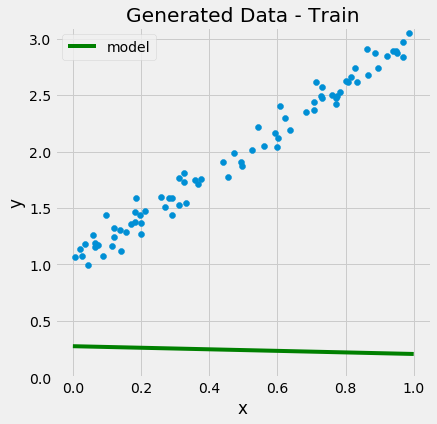

In [16]:
# Initial model prediction
def prediction_figure(x_train, y_train, test_data, predictions):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    ax.scatter(x_train, y_train)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_ylim([0, 3.1])
    ax.set_title('Generated Data - Train')
    ax.plot(test_data, predictions, 'g', label='model')
    ax.legend()
    
    return fig, ax
figure2 = prediction_figure(x_train, y_train, test_data, predictions)

In [17]:
model_trainer.train(n_epochs=10)

[Epoch 0]
training loss: 1.5312181472778321, validation loss: 0.2651233375072479
[Epoch 1]
training loss: 0.2096964806318283, validation loss: 0.13251259922981262
[Epoch 2]
training loss: 0.11470012366771698, validation loss: 0.11563493683934212
[Epoch 3]
training loss: 0.09651125818490983, validation loss: 0.10230321809649467
[Epoch 4]
training loss: 0.08401537388563156, validation loss: 0.09095114842057228
[Epoch 5]
training loss: 0.0740963190793991, validation loss: 0.08178983628749847
[Epoch 6]
training loss: 0.0663081243634224, validation loss: 0.07184234261512756
[Epoch 7]
training loss: 0.05806530714035034, validation loss: 0.06274911016225815
[Epoch 8]
training loss: 0.05078474581241608, validation loss: 0.05599863454699516
[Epoch 9]
training loss: 0.04540037736296654, validation loss: 0.0500551275908947


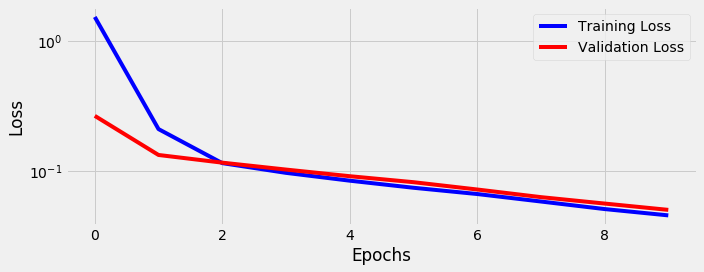

In [18]:
fig = model_trainer.plot_losses()

#### Prediction

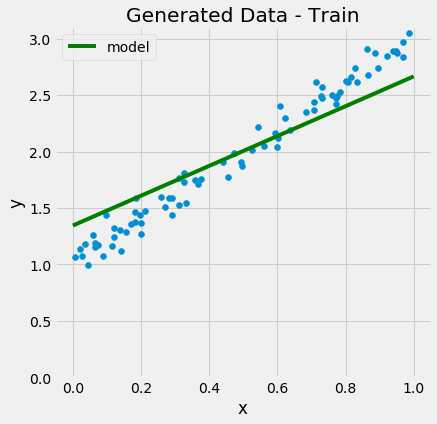

In [19]:
new_predictions = model_trainer.predict(test_data)
figure3 = prediction_figure(x_train, y_train, test_data, new_predictions)

#### Model saving and loading

In [20]:
model_trainer.save_checkpoint('model_checkpoint.pth')

In [21]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.3213]], device='cuda:0')), ('0.bias', tensor([1.3446], device='cuda:0'))])


In [22]:
# Create a new model

lr = 0.1

new_model = nn.Sequential(nn.Linear(1, 1))
new_loss_fn = nn.MSELoss(reduction='mean')
new_optimizer = optim.SGD(new_model.parameters(), lr=lr)

In [23]:
new_model_trainer = ModelTrainer(new_model, new_loss_fn, new_optimizer)
new_model_trainer.load_checkpoint('model_checkpoint.pth')

In [24]:
print(model.state_dict())

OrderedDict([('0.weight', tensor([[1.3213]], device='cuda:0')), ('0.bias', tensor([1.3446], device='cuda:0'))])


In [25]:
new_model_trainer.set_loaders(train_loader, val_loader)
new_model_trainer.train(n_epochs=10)

[Epoch 0]
training loss: 0.03989114947617054, validation loss: 0.04487030766904354
[Epoch 1]
training loss: 0.03619170673191548, validation loss: 0.040030473843216896
[Epoch 2]
training loss: 0.031964263692498204, validation loss: 0.03622535243630409
[Epoch 3]
training loss: 0.028734868764877318, validation loss: 0.03269963525235653
[Epoch 4]
training loss: 0.02593767046928406, validation loss: 0.029728777706623077
[Epoch 5]
training loss: 0.02349555864930153, validation loss: 0.02722768671810627
[Epoch 6]
training loss: 0.021743877232074736, validation loss: 0.02483285591006279
[Epoch 7]
training loss: 0.01990177184343338, validation loss: 0.022842573933303356
[Epoch 8]
training loss: 0.017868750169873236, validation loss: 0.021086784079670906
[Epoch 9]
training loss: 0.016572550125420093, validation loss: 0.019564229995012283


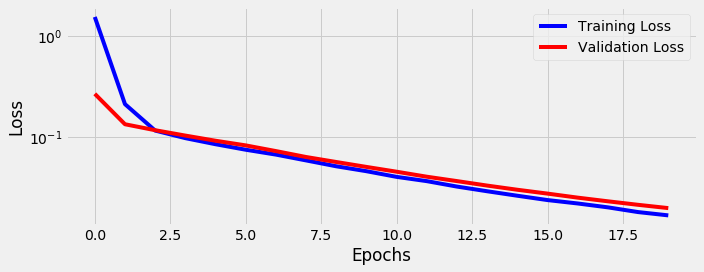

In [26]:
fig = new_model_trainer.plot_losses()

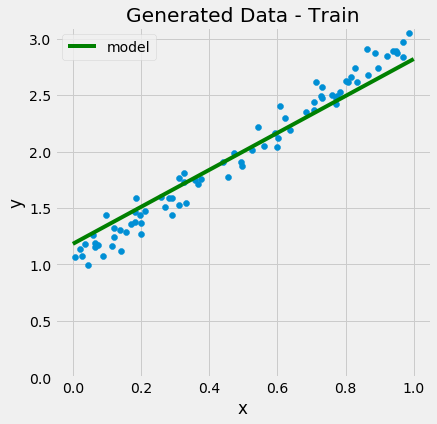

In [27]:
final_predictions = new_model_trainer.predict(test_data)
figure4 = prediction_figure(x_train, y_train, test_data, final_predictions)